In [1]:
#import libraries
import csv
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import statistics
import glob
import requests
from itertools import repeat

In [2]:
#actual COVID-19 cases data for PA
url2 = 'https://raw.githubusercontent.com/IvanVoinovGitHub/Covid19-Analysis-Modeling/main/Data/COVID-19_Aggregate_Cases_Current_Daily_County_Health.csv'
df1 = pd.read_csv(url2)

In [3]:
url = 'https://github.com/reichlab/covid19-forecast-hub/tree/master/data-processed/MUNI-ARIMA'
download = requests.get(url).content

csvStringList = []
hrefStringList = []
urlExtension = []
rawUrls = []
tempList = []
urlExtensionwoutblob = []
urlBeginning = 'https://raw.githubusercontent.com'

urlStringList = str(requests.get(url).text).split(" ")
for i in urlStringList:
  if "csv" in i:
    csvStringList.append(i)

for i in csvStringList:
  if "href" in i and "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in i:
    hrefStringList.append(i)

for i in hrefStringList:
  tempList1 = i.split("\"")
  for x in tempList1:
    if "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in x:
      urlExtension.append(x)

for i in urlExtension:
  newString = ""
  tempList = []
  temp = i.split("/")
  for x in temp:
    if "blob" not in x:
      tempList.append(x)
  for j in range(1, len(tempList)):
    newString += "/" + tempList[j]
  urlExtensionwoutblob.append(newString)


for i in urlExtensionwoutblob:
  finalUrl = urlBeginning + i
  rawUrls.append(finalUrl)

In [4]:
#reading all the raw data, filtering PA cases data, and ensemble back into one dataframe
all_data = []
for url in rawUrls:
    df3=pd.read_csv(url)
    df2_case = df3[df3['target'].str.contains('case')]
    df2_casesPA = df2_case[(df2_case["type"]=="point") & (df2_case["location"]=="42")]
    all_data.append(df2_casesPA)

In [5]:
len(all_data)

43

In [6]:
df2 = pd.concat(all_data)
df2.head(5)

,location,type,quantile,value,target_end_date,forecast_date,target
4864,42,point,NaN,12206.0,2021-05-15,2021-05-10,1 wk ahead inc case
4896,42,point,NaN,10679.0,2021-05-22,2021-05-10,2 wk ahead inc case
4928,42,point,NaN,10404.0,2021-05-29,2021-05-10,3 wk ahead inc case
4960,42,point,NaN,10459.0,2021-06-05,2021-05-10,4 wk ahead inc case
4864,42,point,NaN,9711.0,2021-05-22,2021-05-17,1 wk ahead inc case


In [7]:
#convert date to datetime object
df1['Date'] = pd.to_datetime(df1['Date'])
df2['forecast_date'] = pd.to_datetime(df2['forecast_date'])
df2['target_end_date'] = pd.to_datetime(df2['target_end_date'])

In [8]:
#sort datasets by date
df1.sort_values(by='Date')
df2.sort_values(by='target_end_date')

,location,type,quantile,value,target_end_date,forecast_date,target
4864,42,point,NaN,12206.0,2021-05-15,2021-05-10,1 wk ahead inc case
4896,42,point,NaN,10679.0,2021-05-22,2021-05-10,2 wk ahead inc case
4864,42,point,NaN,9711.0,2021-05-22,2021-05-17,1 wk ahead inc case
4928,42,point,NaN,10404.0,2021-05-29,2021-05-10,3 wk ahead inc case
4896,42,point,NaN,8877.0,2021-05-29,2021-05-17,2 wk ahead inc case
...,...,...,...,...,...,...,...
31984,42,point,NaN,29445.0,2022-03-19,2022-02-21,4 wk ahead inc case
31360,42,point,NaN,8831.0,2022-03-19,2022-03-14,1 wk ahead inc case
31656,42,point,NaN,10498.0,2022-03-26,2022-03-14,2 wk ahead inc case
31928,42,point,NaN,10269.0,2022-04-02,2022-03-14,3 wk ahead inc case


In [9]:
#filterinng out data for PA (FIPS code = 42)
df2_2 = df2[df2['target'].str.contains('1')]
df2_2.shape

(43, 7)

In [10]:
#finding weekly increase in cases in PA
df_weekly=df2_2.groupby('target_end_date').agg('last').reset_index()
df_weekly.rename(
    columns={"target_end_date":"Date"},inplace=True)
#df_weekly

In [11]:
#creating a column for daily additions
df_weekly["dayRate"] = df_weekly["value"] / 7
mask = (df_weekly['Date'] <= '2022-03-02')
df_weekly = df_weekly.loc[mask]
df_weekly.head(5)

,Date,location,type,quantile,value,forecast_date,target,dayRate
0,2021-05-15,42,point,NaN,12206.0,2021-05-10,1 wk ahead inc case,1743.714286
1,2021-05-22,42,point,NaN,9711.0,2021-05-17,1 wk ahead inc case,1387.285714
2,2021-05-29,42,point,NaN,8446.0,2021-05-24,1 wk ahead inc case,1206.571429
3,2021-06-05,42,point,NaN,4870.0,2021-05-31,1 wk ahead inc case,695.714286
4,2021-06-12,42,point,NaN,2863.0,2021-06-07,1 wk ahead inc case,409.000000


In [12]:
df_weekly.tail(5)

,Date,location,type,quantile,value,forecast_date,target,dayRate
37,2022-01-29,42,point,NaN,103910.0,2022-01-24,1 wk ahead inc case,14844.285714
38,2022-02-05,42,point,NaN,70811.0,2022-01-31,1 wk ahead inc case,10115.857143
39,2022-02-12,42,point,NaN,29629.0,2022-02-07,1 wk ahead inc case,4232.714286
40,2022-02-19,42,point,NaN,16858.0,2022-02-14,1 wk ahead inc case,2408.285714
41,2022-02-26,42,point,NaN,22373.0,2022-02-21,1 wk ahead inc case,3196.142857


In [21]:
# creating a list of predictions from the model data
predictions = []
for i in df_weekly["dayRate"]:
    predictions.extend(repeat(i,7))
del predictions[-2:]
#preds = pd.DataFrame(predictions)
#preds.drop(preds.tail(2).index,inplace=True) 
print(predictions)

[1743.7142857142858, 1743.7142857142858, 1743.7142857142858, 1743.7142857142858, 1743.7142857142858, 1743.7142857142858, 1743.7142857142858, 1387.2857142857142, 1387.2857142857142, 1387.2857142857142, 1387.2857142857142, 1387.2857142857142, 1387.2857142857142, 1387.2857142857142, 1206.5714285714287, 1206.5714285714287, 1206.5714285714287, 1206.5714285714287, 1206.5714285714287, 1206.5714285714287, 1206.5714285714287, 695.7142857142857, 695.7142857142857, 695.7142857142857, 695.7142857142857, 695.7142857142857, 695.7142857142857, 695.7142857142857, 409.0, 409.0, 409.0, 409.0, 409.0, 409.0, 409.0, 262.0, 262.0, 262.0, 262.0, 262.0, 262.0, 262.0, 164.28571428571428, 164.28571428571428, 164.28571428571428, 164.28571428571428, 164.28571428571428, 164.28571428571428, 164.28571428571428, 149.28571428571428, 149.28571428571428, 149.28571428571428, 149.28571428571428, 149.28571428571428, 149.28571428571428, 149.28571428571428, 166.28571428571428, 166.28571428571428, 166.28571428571428, 166.2857

In [22]:
len(predictions)

292

In [23]:
#select all the dates to be merged with prediction list
mask = (df1['Date'] >= '2021-05-15') & (df1['Date'] <= '2022-03-02')
df1_copy = df1.loc[mask]
df1_copy = df1_copy.groupby(["Date"]).sum().reset_index()
df1_copy.head(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude
0,2021-05-15,2140,3686.1,2398022,25603978,580.5,1090.7,637395.5,2860489,-5275.682283,2774.207671
1,2021-05-16,1630,3630.0,2399652,25603978,444.6,1076.0,637840.2,2860489,-5275.682283,2774.207671
2,2021-05-17,3930,3428.7,2403582,25603978,1207.7,1007.3,639047.1,2860489,-5275.682283,2774.207671
3,2021-05-18,2554,3175.9,2406136,25603978,716.0,940.4,639763.1,2860489,-5275.682283,2774.207671
4,2021-05-19,2854,2974.2,2408990,25603978,922.1,892.8,640685.2,2860489,-5275.682283,2774.207671


In [24]:
len(df1_copy)

292

In [25]:
# assigning predictions list to the actual dataframe
df1_copy['Prediction'] = predictions

In [26]:
df1_copy.head(20)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude,Prediction
0,2021-05-15,2140,3686.1,2398022,25603978,580.5,1090.7,637395.5,2860489,-5275.682283,2774.207671,1743.714286
1,2021-05-16,1630,3630.0,2399652,25603978,444.6,1076.0,637840.2,2860489,-5275.682283,2774.207671,1743.714286
2,2021-05-17,3930,3428.7,2403582,25603978,1207.7,1007.3,639047.1,2860489,-5275.682283,2774.207671,1743.714286
3,2021-05-18,2554,3175.9,2406136,25603978,716.0,940.4,639763.1,2860489,-5275.682283,2774.207671,1743.714286
4,2021-05-19,2854,2974.2,2408990,25603978,922.1,892.8,640685.2,2860489,-5275.682283,2774.207671,1743.714286
5,2021-05-20,4094,3025.7,2413084,25603978,1238.8,909.6,641924.0,2860489,-5275.682283,2774.207671,1743.714286
6,2021-05-21,2772,2853.8,2415856,25603978,854.0,851.9,642777.5,2860489,-5275.682283,2774.207671,1743.714286
7,2021-05-22,1920,2822.0,2417776,25603978,541.1,846.4,643318.9,2860489,-5275.682283,2774.207671,1387.285714
8,2021-05-23,1272,2770.6,2419048,25603978,338.5,830.9,643656.4,2860489,-5275.682283,2774.207671,1387.285714
9,2021-05-24,2486,2564.4,2421534,25603978,792.1,771.7,644448.9,2860489,-5275.682283,2774.207671,1387.285714


In [27]:
# renaming the dataframe for graphing
merged_df_new = df1_copy

In [28]:
merged_df_new.shape

(292, 12)

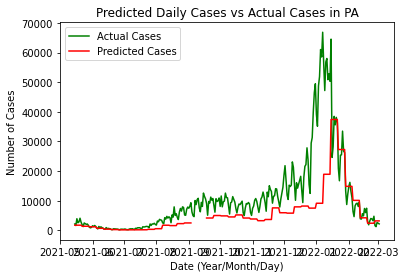

In [29]:
#Create plot of Actual vs. Predicted Cases

#Actual Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['New Cases'], color='g', label='Actual Cases')

#Predicted Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['Prediction'], color='r', label='Predicted Cases')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Number of Cases') 
plt.title("Predicted Daily Cases vs Actual Cases in PA")

#Display Plot
plt.legend()
plt.show()

In [30]:
#error calculations
#confirmed = merged_df_new['Actual']
#projected = merged_df_new['Prediction']
error = []
rawerror = []

for index, row in merged_df_new.iterrows():
  rawerror.append(-1*(row['New Cases'] - row["Prediction"]) / row['New Cases'])
  error.append((abs(row['New Cases'] - row["Prediction"])) / row['New Cases'])

underpredictCount = 0
overpredictCount = 0
for x in rawerror:
  if x < 0:
    underpredictCount += 1
  elif x > 0:
    overpredictCount += 1

underpredictPerecentage = underpredictCount / len(rawerror)
overpredictPercentage = 1 - underpredictPerecentage

print(underpredictCount)
print(underpredictPerecentage)
print(overpredictCount)
print(overpredictPercentage)
print(len(error))

print(error)
print(rawerror)

238
0.815068493150685
40
0.18493150684931503
292
[0.1851802403204272, 0.06976336546888698, 0.5563067975281716, 0.3172614386396688, 0.38902793072379616, 0.5740805359759927, 0.3709544423830138, 0.2774553571428572, 0.09063342318059293, 0.4419606941730836, 0.3817799847211612, 0.3186219477968005, 0.34930313588850176, 0.17521657890266693, 0.16689693285437976, 0.43298269426535474, 0.18291316526610654, 0.2265567765567765, 0.05292666517156305, 0.2696298858526461, 0.09552366673805947, 0.11934900542495486, 0.4315108759553203, 0.47374108493624384, 0.22698412698412704, 0.4163470757430489, 0.24868867633446473, 0.05984555984555991, 0.007389162561576354, 0.1298342541436464, 0.5658174097664543, 0.274822695035461, 0.38772455089820357, 0.32730263157894735, 0.201171875, 0.015037593984962405, 0.11965811965811966, 0.5130111524163569, 0.4717741935483871, 0.42290748898678415, 0.3878504672897196, 0.35784313725490197, 0.413265306122449, 0.1167434715821813, 0.5933521923620934, 0.5721726190476191, 0.5743893412287

In [31]:
#accuracy calculations
accuracy = []

for i in error:
  accuracy.append(1 - i)

print(accuracy)

[0.8148197596795728, 0.930236634531113, 0.4436932024718284, 0.6827385613603312, 0.6109720692762038, 0.42591946402400727, 0.6290455576169862, 0.7225446428571428, 0.909366576819407, 0.5580393058269164, 0.6182200152788389, 0.6813780522031996, 0.6506968641114983, 0.824783421097333, 0.8331030671456202, 0.5670173057346453, 0.8170868347338934, 0.7734432234432235, 0.9470733348284369, 0.730370114147354, 0.9044763332619405, 0.8806509945750451, 0.5684891240446797, 0.5262589150637562, 0.7730158730158729, 0.583652924256951, 0.7513113236655353, 0.94015444015444, 0.9926108374384236, 0.8701657458563536, 0.43418259023354566, 0.725177304964539, 0.6122754491017964, 0.6726973684210527, 0.798828125, 0.9849624060150376, 0.8803418803418803, 0.48698884758364314, 0.5282258064516129, 0.5770925110132159, 0.6121495327102804, 0.642156862745098, 0.5867346938775511, 0.8832565284178187, 0.40664780763790664, 0.42782738095238093, 0.42561065877128046, 0.4588986432561851, 0.3525444512568976, 0.5009587727708533, 0.6068524

In [ ]:
#Create Error and Accuracy Column and insert list data
merged_df_new['Error'] = error
merged_df_new['Accuracy'] = accuracy
merged_df_new['RawError'] = rawerror

print(merged_df_new)

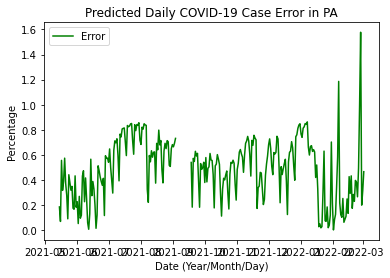

In [33]:
from IPython.core.pylabtools import figsize
#Create plot of Error

#Error Line
plt.plot(merged_df_new['Date'], merged_df_new['Error'], color='g', label='Error')


#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Error in PA")
#Display Plot
plt.legend()

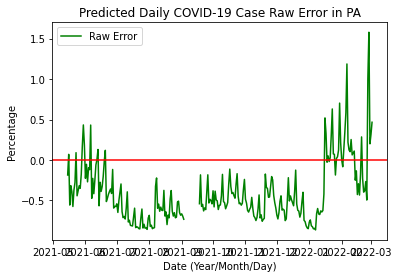

In [34]:
#Create plot of Raw Error

#Raw Error Line
plt.plot(merged_df_new['Date'], merged_df_new['RawError'], color='g', label='Raw Error')
plt.axhline(y=0.0, color='r', linestyle='-')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Raw Error in PA")
#Display Plot
plt.legend()
plt.show()

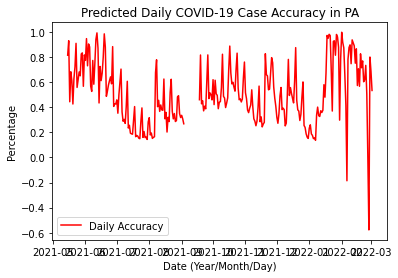

In [35]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [36]:
#Calculate Weekly Accuracy Averages
weeklyAccuracy = 0
averageWeeklyAccuracy = []
length = len(accuracy) #   =245
amountOfWeeks = int(length / 7) #   =35
remainderDays = length % 7 #  

i = 0
while i < length:
  weeklyAccuracy += accuracy[i]
  if (i + 1) % 7 == 0 and amountOfWeeks > 0:
    averageWeeklyAccuracy.append(weeklyAccuracy / 7)
    amountOfWeeks -= 1
    weeklyAccuracy = 0
  if remainderDays > 0:
    if (i + 1) % remainderDays == 0 and amountOfWeeks == 0:
      averageWeeklyAccuracy.append(weeklyAccuracy / remainderDays)
      weeklyAccuracy = 0
  i += 1

weeklyDateList = []
i = 0
weeklyDateList.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 7 == 0:
    weeklyDateList.append(merged_df_new['Date'][i])
  i += 1

In [37]:
len(weeklyDateList)

42

In [38]:
#del averageWeeklyAccuracy[-1:]
len(averageWeeklyAccuracy)

42

In [39]:
#Create Dataframe for Weekly Accuracy
i = 0
data = []
while i < len(averageWeeklyAccuracy):
  data.append([weeklyDateList[i], averageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Week Of', 'Average Weekly Accuracy'])

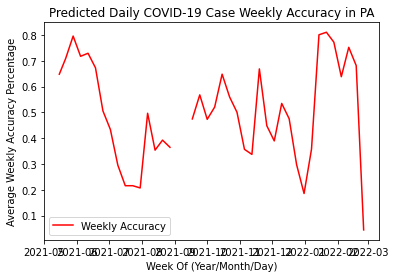

In [40]:
#Create plot of Weekly Accuracy

#Accuracy Line
plt.plot(df['Week Of'], df['Average Weekly Accuracy'], color='r', label='Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Week Of (Year/Month/Day)') 
plt.ylabel('Average Weekly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [41]:
#Create Running Weekly Average
runningweeklyAccuracy = 0
runningAverageWeeklyAccuracy = []
length = len(accuracy)

i = 1
j = 8
#Add first week average
runningAverageWeeklyAccuracy.append(averageWeeklyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningweeklyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAverageWeeklyAccuracy.append(runningweeklyAccuracy / 7)
  runningweeklyAccuracy = 0

  i += 1
  j += 1

In [42]:
#Create Dataframe for Running Weekly Accuracy
i = 0
data = []
while i < len(runningAverageWeeklyAccuracy):
  data.append([merged_df_new['Date'][i], runningAverageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Weekly Average Accuracy'])

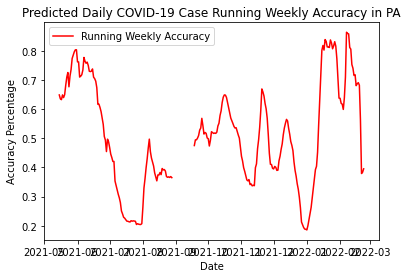

In [43]:
#Create plot of Running Weekly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='r', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

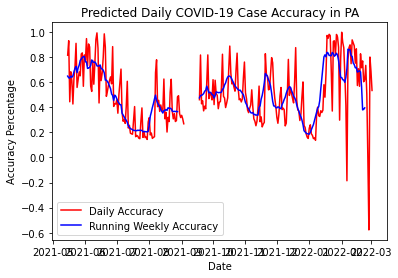

In [44]:
#Plot with combined daily accuracy and running weekly accuracy

#Daily Accuracy
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Running Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='b', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
#merged_df_new.to_csv('DDS_everyday_predictions.csv')

In [45]:
#Calculate Monthly Accuracy Averages
#We are going to use an average of 30 days per month for these calculations

monthlyAccuracy = 0
averageMonthlyAccuracy = []
amountOfMonths = int(length / 30)
remainderDays = length % 30

i = 0
while i < length:
  monthlyAccuracy += accuracy[i]
  if (i + 1) % 30 == 0 and amountOfMonths > 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / 30)
    amountOfMonths -= 1
    monthlyAccuracy = 0
  if (i + 1) % remainderDays == 0 and remainderDays > 0 and amountOfMonths == 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / remainderDays)
    monthlyAccuracy = 0
  i += 1

weeklyDateListForMonths = []
i = 0
weeklyDateListForMonths.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 30 == 0:
    weeklyDateListForMonths.append(merged_df_new['Date'][i])
  i += 1


In [46]:
del averageMonthlyAccuracy[-1:]
len(averageMonthlyAccuracy)

9

In [47]:
#Create Dataframe for Monthly Accuracy
i = 0
data = []
while i < len(averageMonthlyAccuracy):
  data.append([weeklyDateListForMonths[i], averageMonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Month Of', 'Average Monthly Accuracy'])

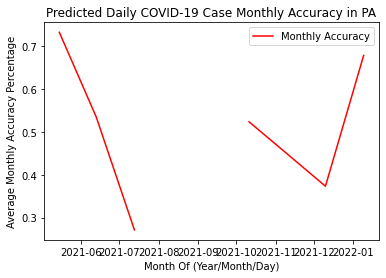

In [48]:
#Create plot of Monthly Accuracy

#Accuracy Line
plt.plot(df['Month Of'], df['Average Monthly Accuracy'], color='r', label='Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Month Of (Year/Month/Day)') 
plt.ylabel('Average Monthly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [49]:
#Calculate Running Monthly Accuracy

runningmonthlyAccuracy = 0
runningAveragemonthlyAccuracy = []
length = len(accuracy)

i = 1
j = 31
#Add first week average
runningAveragemonthlyAccuracy.append(averageMonthlyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningmonthlyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAveragemonthlyAccuracy.append(runningmonthlyAccuracy / 30)
  runningmonthlyAccuracy = 0

  i += 1
  j += 1

In [50]:
#Create Dataframe for Running Monthly Accuracy
i = 0
data = []
while i < len(runningAveragemonthlyAccuracy):
  data.append([merged_df_new['Date'][i], runningAveragemonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Monthly Average Accuracy'])

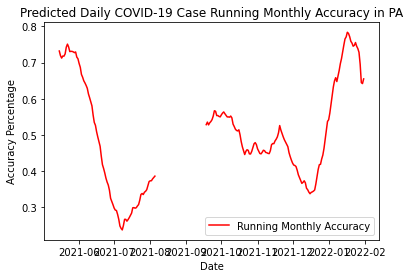

In [51]:
#Create plot of Running Monthly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Monthly Average Accuracy'], color='r', label='Running Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [52]:
#Calculate Yearly Accuracy Averages
#We are going to use an average of 365 days per year for these calculations

yearlyAccuracy = 0
averageYearlyAccuracy = []
amountOfYears = int(length / 365)
remainderDays = length % 365

i = 0
while i < length:
  yearlyAccuracy += accuracy[i]
  if (i + 1) % 365 == 0 and amountOfYears > 0:
    averageYearlyAccuracy.append(yearlyAccuracy / 365)
    amountOfYears -= 1
    yearlyAccuracy = 0
  if (i + 1) % remainderDays == 0 and remainderDays > 0 and amountOfYears == 0:
    averageYearlyAccuracy.append(yearlyAccuracy / remainderDays)
    yearlyAccuracy = 0
  i += 1

weeklyDateListForYears = []
i = 0
weeklyDateListForYears.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 365 == 0:
    weeklyDateListForYears.append(merged_df_new['Date'][i])
  i += 1

In [53]:
print(averageYearlyAccuracy)

[nan]


In [56]:
#Calculate Overall Accuracy
overallAccuracy = merged_df_new['Accuracy'].mean()
print(overallAccuracy)

0.5090723142354445


In [57]:
#Create new dataframe for year 2022
data_2022 = merged_df_new[(merged_df_new['Date'] > '2022-01-01')]

In [58]:
#create error and accuracy lists for 2022
error_2022=[]
for index, row in data_2022.iterrows():
  error_2022.append((abs(row['New Cases'] - row["Prediction"])) / row['New Cases'])

accuracy_2022 = []
for i in error_2022:
  accuracy_2022.append(1 - i)

In [59]:
#check head of 2022 data
data_2022.head(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude,Prediction,Error,Accuracy,RawError
232,2022-01-02,35128,38695.9,4203914,25603978,6449.2,7426.4,1172327.7,2860489,-5275.682283,2774.207671,9141.571429,0.739764,0.260236,-0.739764
233,2022-01-03,48768,41456.9,4252682,25603978,9816.9,8055.2,1182144.5,2860489,-5275.682283,2774.207671,9141.571429,0.812550,0.187450,-0.812550
234,2022-01-04,51898,44396.0,4304580,25603978,10744.4,8691.2,1192888.2,2860489,-5275.682283,2774.207671,9141.571429,0.823855,0.176145,-0.823855
235,2022-01-05,61004,47411.2,4365584,25603978,11662.5,9215.5,1204551.4,2860489,-5275.682283,2774.207671,9141.571429,0.850148,0.149852,-0.850148
236,2022-01-06,58492,49136.1,4424076,25603978,12854.6,9728.8,1217406.1,2860489,-5275.682283,2774.207671,9141.571429,0.843712,0.156288,-0.843712


([<matplotlib.axis.XTick at 0x7fed1f0ded50>,
 <a list of 9 Text major ticklabel objects>)

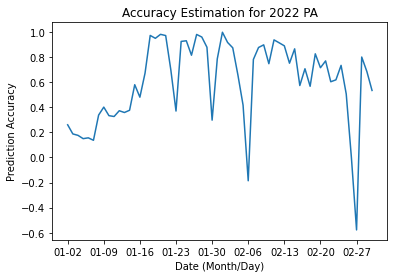

In [60]:
#create plot for 2022 accuracy
plt.xlabel('Date (Month/Day)') 
plt.ylabel('Prediction Accuracy') 
plt.title("Accuracy Estimation for 2022 PA")

plt.plot(data_2022['Date'].dt.strftime('%m-%d'), accuracy_2022, label='Accuracy 2022')
plt.xticks(np.arange(0, len(data_2022['Date']), 7))

In [61]:
#cleans accuracy list of all nan values
newlist = [x for x in accuracy if math.isnan(x) == False]
print(newlist)

[0.8148197596795728, 0.930236634531113, 0.4436932024718284, 0.6827385613603312, 0.6109720692762038, 0.42591946402400727, 0.6290455576169862, 0.7225446428571428, 0.909366576819407, 0.5580393058269164, 0.6182200152788389, 0.6813780522031996, 0.6506968641114983, 0.824783421097333, 0.8331030671456202, 0.5670173057346453, 0.8170868347338934, 0.7734432234432235, 0.9470733348284369, 0.730370114147354, 0.9044763332619405, 0.8806509945750451, 0.5684891240446797, 0.5262589150637562, 0.7730158730158729, 0.583652924256951, 0.7513113236655353, 0.94015444015444, 0.9926108374384236, 0.8701657458563536, 0.43418259023354566, 0.725177304964539, 0.6122754491017964, 0.6726973684210527, 0.798828125, 0.9849624060150376, 0.8803418803418803, 0.48698884758364314, 0.5282258064516129, 0.5770925110132159, 0.6121495327102804, 0.642156862745098, 0.5867346938775511, 0.8832565284178187, 0.40664780763790664, 0.42782738095238093, 0.42561065877128046, 0.4588986432561851, 0.3525444512568976, 0.5009587727708533, 0.6068524

In [62]:
#calculate variance and st deviation of accuracy
var = sum((l-overallAccuracy)**2 for l in newlist) / len(newlist)
st_dev = math.sqrt(var)
print(var)
print(st_dev)

0.0588249401465849
0.2425385333232328


In [63]:
#calculate median of accuracy
accMedian = statistics.median(newlist)
print(accMedian)

0.4815241171755565


In [64]:
#Seperate Running Weekly Average plot into 3 plots for the 3 variants: Original, Delta, Omicron

# Start Date - May 20th 2021
# Delta: May 20th 2021 - December 1st 2021
# Omicron: December 1st 2021 - Present

In [65]:
type(merged_df_new['Date'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [66]:
merged_df_new.index[merged_df_new['Date']=='2021-05-20'].tolist()

[5]

In [67]:
merged_df_new.index[merged_df_new['Date']=='2021-12-01'].tolist()

[200]

In [68]:
#print(merged_inner)
standardVariantDF = merged_df_new[:5]
deltaVariantDF = merged_df_new[5:200]
omicronVariantDF = merged_df_new[200:]

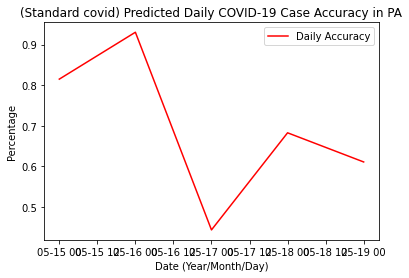

In [69]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(standardVariantDF['Date'], standardVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Standard covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

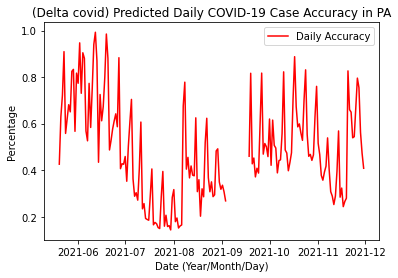

In [70]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(deltaVariantDF['Date'], deltaVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Delta covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

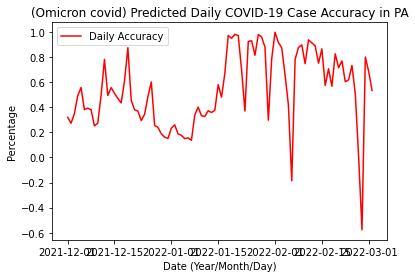

In [71]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(omicronVariantDF['Date'], omicronVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Omicron covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()